In [7]:
import geopandas as gpd
import leafmap
from shapely.ops import unary_union
from shapely.geometry import Point, mapping, box, shape
import shapely
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from einops import rearrange
import sys
sys.path.append("..")

from src.models.datamodule import MineDataModule

In [2]:

os.getcwd()
os.chdir("..")
root = os.path.dirname(os.getcwd())
root = root + "/workspaces/mine-segmentation" # uncomment when running in Lightning Studios
root

'/teamspace/studios/this_studio/workspaces/mine-segmentation'

In [3]:
TRAIN_CHIP_DIR = "data/processed/chips/npy/train/chips/"
TRAIN_LABEL_DIR = "data/processed/chips/npy/train/labels/"
VAL_CHIP_DIR = "data/processed/chips/npy/val/chips/"
VAL_LABEL_DIR = "data/processed/chips/npy/val/labels/"
TEST_CHIP_DIR = "data/processed/chips/npy/test/chips/"
TEST_LABEL_DIR = "data/processed/chips/npy/test/labels/"

METADATA_PATH = "configs/cnn/cnn_segment_metadata.yaml"
BATCH_SIZE = 1
NUM_WORKERS = 4
PLATFORM = "sentinel-2-l2a"

is_lightning = True
if is_lightning:
    METADATA_PATH = root + "/" + METADATA_PATH
    TRAIN_CHIP_DIR = root +  "/" +TRAIN_CHIP_DIR
    TRAIN_LABEL_DIR = root + "/" + TRAIN_LABEL_DIR
    VAL_CHIP_DIR = root + "/" + VAL_CHIP_DIR
    VAL_LABEL_DIR = root + "/" + VAL_LABEL_DIR
    TEST_CHIP_DIR = root + "/" + TEST_CHIP_DIR
    TEST_LABEL_DIR = root + "/" + TEST_LABEL_DIR

### Check number of chips

In [4]:
# check number of chips
train_chip_files = os.listdir(TRAIN_CHIP_DIR)
val_chip_files = os.listdir(VAL_CHIP_DIR)
test_chip_files = os.listdir(TEST_CHIP_DIR)

len(train_chip_files), len(val_chip_files), len(test_chip_files)

(5921, 1530, 776)

### Plot chips, including data tranformations

In [5]:
import matplotlib.pyplot as plt

datamodule = MineDataModule(
    train_chip_dir=TRAIN_CHIP_DIR,
    train_label_dir=TRAIN_LABEL_DIR,
    val_chip_dir=VAL_CHIP_DIR,
    val_label_dir=VAL_LABEL_DIR,
    test_chip_dir=TEST_CHIP_DIR,
    test_label_dir=TEST_LABEL_DIR,
    metadata_path=METADATA_PATH,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    platform=PLATFORM,
    data_augmentation=True,
)

datamodule.setup(stage="fit")

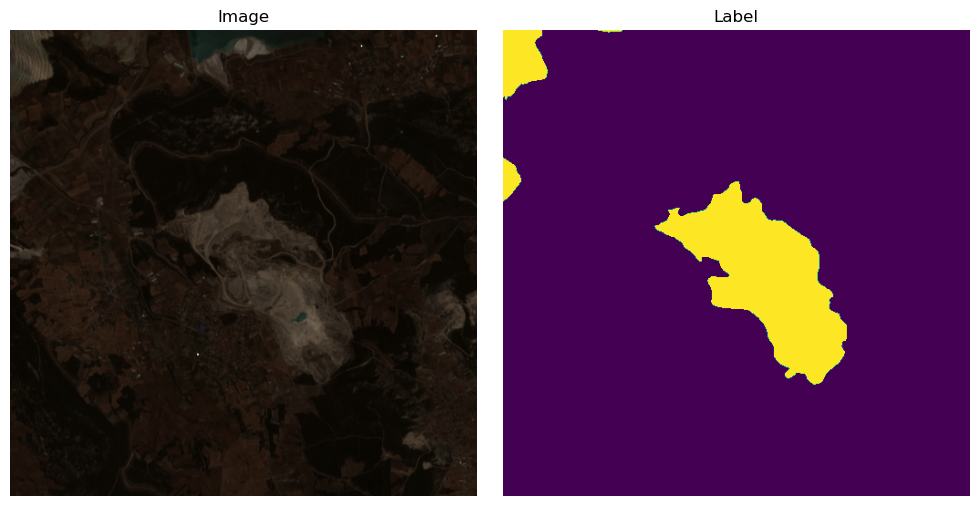

In [16]:
batch = next(iter(datamodule.train_dataloader()))

batch["pixels"].shape, batch["label"].shape

# squeeze the batch size dimension
pixels = batch["pixels"].squeeze(0)
label = batch["label"].squeeze(0)

# rearrange for plotting
pixels = rearrange(pixels, "c h w -> h w c")
label = rearrange(label, "h w -> h w")

# normalize
pixels = (pixels - pixels.min()) / (pixels.max() - pixels.min())

# plot the image and label side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# plot the image
axes[0].imshow(pixels)
axes[0].axis("off")
axes[0].set_title("Image", fontsize=12)

# plot the label
axes[1].imshow(label, cmap="viridis")
axes[1].axis("off")
axes[1].set_title("Label", fontsize=12)

plt.tight_layout()
plt.show()